In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay

In [2]:
scharr_design = Overlay("scharr.bit")

In [3]:
for i in scharr_design.ip_dict:
    print(i)

scharr_accel_0
axi_dma_0
processing_system7_0


In [4]:
dma = scharr_design.axi_dma_0
scharr = scharr_design.scharr_accel_0

In [5]:
image_path = "/home/xilinx/jupyter_notebooks/images/Emir_Abdelkader_4K.jpg"
original_image = Image.open(image_path)

Image size: 3840x2160 pixels.


<Figure size 864x576 with 0 Axes>

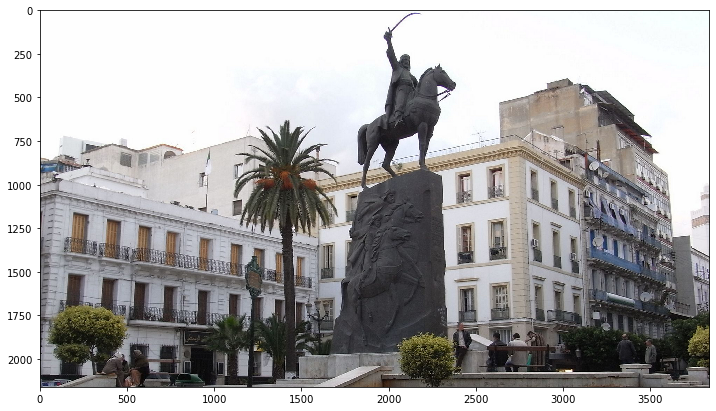

In [6]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

width, height = original_image.size
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(original_image)

We now allocate memory to process data on PL.
Data is provided as contiguous memory blocks.
The size of the buffer depends on the size of the input or output data.
The image dimensions extracted from the read image are used to allocate contiguous memory blocks.   
We will call `allocate()` to perform the allocation.

In [7]:
in_buffer = allocate(shape=(height, width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(height, width), 
                            dtype=np.uint8, cacheable=1)

In [8]:
in_buffer[:] = np.array(original_image)

In [9]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    scharr.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [10]:
scharr.register_map.rows = height
scharr.register_map.cols = width
scharr.register_map.alpha = 0.5

Now we can perform the sobel operation.

In [11]:
run_kernel()
edge_image = Image.fromarray(out_buffer)

## Display resized image

Image size: 3840x2160 pixels.


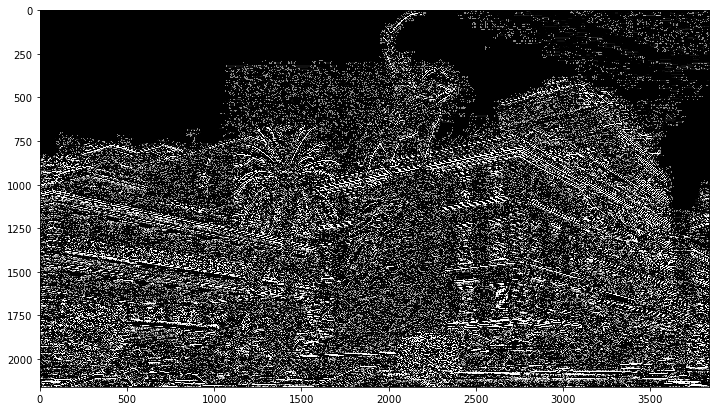

In [12]:
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = _ = plt.imshow(edge_image,cmap='gray', vmin=0, vmax=255)

We can time the resize in PL operation.

In [32]:
%%timeit
run_kernel()
edge_image = Image.fromarray(out_buffer)

147 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Finally we need to free all the contiguous memory buffers.

In [33]:
del in_buffer
del out_buffer

In [17]:
from PIL import Image
import numpy as np
img = np.array(original_image).astype(np.uint8)
# Apply gray scale
gray_img = np.round(0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]).astype(np.uint8)
# Sobel Operator
h, w = gray_img.shape
# define filters
horizontal = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])  # s2
vertical = np.array([[-3, -10, 3], [0, 0, 0], [3, 10, 3]])  # s1

# define images with 0s
newhorizontalImage = np.zeros((h, w))
newverticalImage = np.zeros((h, w))
newgradientImage = np.zeros((h, w))

In [18]:
# offset by 1
for i in range(1, h - 1):
    for j in range(1, w - 1):
        horizontalGrad = (horizontal[0, 0] * gray_img[i - 1, j - 1]) + \
                         (horizontal[0, 1] * gray_img[i - 1, j]) + \
                         (horizontal[0, 2] * gray_img[i - 1, j + 1]) + \
                         (horizontal[1, 0] * gray_img[i, j - 1]) + \
                         (horizontal[1, 1] * gray_img[i, j]) + \
                         (horizontal[1, 2] * gray_img[i, j + 1]) + \
                         (horizontal[2, 0] * gray_img[i + 1, j - 1]) + \
                         (horizontal[2, 1] * gray_img[i + 1, j]) + \
                         (horizontal[2, 2] * gray_img[i + 1, j + 1])

        newhorizontalImage[i - 1, j - 1] = abs(horizontalGrad)

        verticalGrad = (vertical[0, 0] * gray_img[i - 1, j - 1]) + \
                       (vertical[0, 1] * gray_img[i - 1, j]) + \
                       (vertical[0, 2] * gray_img[i - 1, j + 1]) + \
                       (vertical[1, 0] * gray_img[i, j - 1]) + \
                       (vertical[1, 1] * gray_img[i, j]) + \
                       (vertical[1, 2] * gray_img[i, j + 1]) + \
                       (vertical[2, 0] * gray_img[i + 1, j - 1]) + \
                       (vertical[2, 1] * gray_img[i + 1, j]) + \
                       (vertical[2, 2] * gray_img[i + 1, j + 1])

        newverticalImage[i - 1, j - 1] = abs(verticalGrad)

        # Edge Magnitude
        #mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
        mag = (horizontalGrad *0.5) + (verticalGrad * 0.5)
        newgradientImage[i - 1, j - 1] = mag

Image size: 3840x2160 pixels.


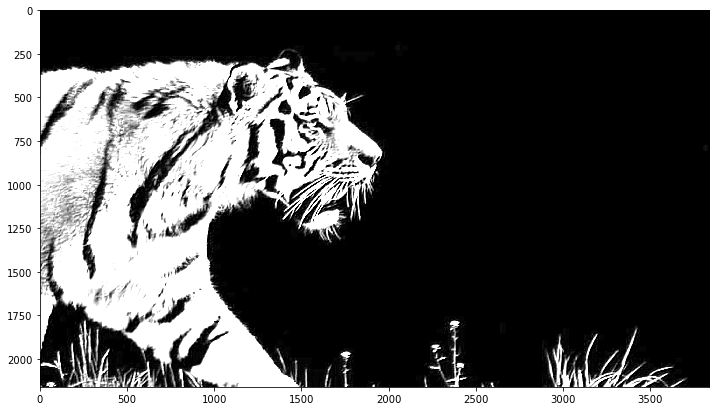

In [19]:
print("Image size: {}x{} pixels.".format(w, h))
plt.figure(figsize=(12, 10));
_ = plt.imshow(newgradientImage, cmap='gray', vmin=0, vmax=255)

In [2]:
import cv2

Image size: 3840x2160 pixels.


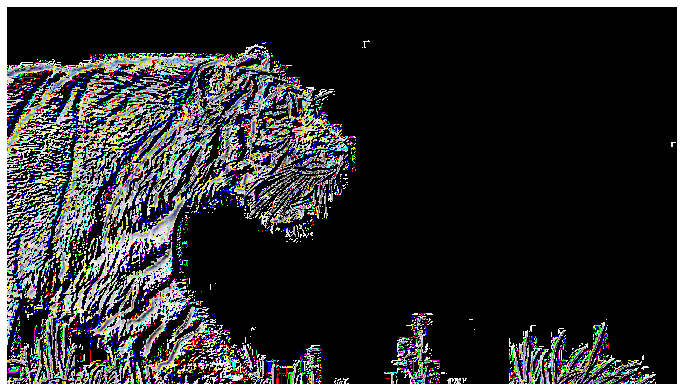

In [8]:
original_image2 = cv2.imread("/home/xilinx/jupyter_notebooks/images/Tiger.jpg")
original_image2 = cv2.cvtColor(original_image2, cv2.COLOR_BGR2RGB)
gradx = cv2.Scharr(original_image2, cv2.CV_32F, 1, 0, scale=1, borderType=cv2.BORDER_CONSTANT)
grady = cv2.Scharr(original_image2, cv2.CV_32F, 0, 1, scale=1, borderType=cv2.BORDER_CONSTANT)
grady= cv2.accumulateWeighted(gradx, grady, 0.5)
height, width, channels =grady.shape
print("Image size: {}x{} pixels.".format(width, height))

plt.figure(figsize=(12, 10));
plt.axis("off")
_ =plt.imshow((grady * 255).astype(np.uint8), cmap='gray', vmin=0, vmax=255)

In [7]:
%%timeit
gradx = cv2.Scharr(original_image2, cv2.CV_32F, 1, 0, scale=1, borderType=cv2.BORDER_CONSTANT)
grady = cv2.Scharr(original_image2, cv2.CV_32F, 0, 1, scale=1, borderType=cv2.BORDER_CONSTANT)
grady= cv2.accumulateWeighted(gradx, grady, 0.5)

4.17 s ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
